In [1]:
#FUNCIONES DE ACTIVACIÓN Y COSTE PARA REDES NEURONALES MULTICAPA
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.special import expit,softmax

class function(object):
    def __init__(self,funcion,derivative=None,rand_init=(0,1)):
        self.F=funcion
        self.D=derivative
        self.Rand_init=rand_init

lineal=function(funcion=lambda x:x, derivative=lambda x:1, rand_init=(-1,1))
sigm=function(funcion=lambda x: expit(x), derivative=lambda x: expit(x)*(1-expit(x)), rand_init=(0,1))
tanh1=function(funcion=lambda x:np.tanh(x), derivative=lambda x:1-np.tanh(x)**2, rand_init=(-1,1))
relu=function(funcion=lambda x: np.maximum(0, x), derivative=lambda x: np.where(x<=0,0,1), rand_init=(0,1))
softmaxf=function(funcion=lambda x: softmax(x), derivative=lambda x:softmax(x)*(1-softmax(x)), rand_init=(0,1))
tanh=function(funcion=lambda x:(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)),
              derivative=lambda x:1-((np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x)))**2,
              rand_init=(-1,1))
Funciones={"relu":relu, "sigm":sigm, "relu":relu, "tanh":tanh, "tanh1":tanh1, "lineal":lineal, "softmax":softmaxf}

mse=function(funcion=lambda Yp, Yr: np.mean((Yp - Yr) ** 2) , derivative=lambda Yp, Yr: (Yp - Yr))
cross_entropy=function(funcion=lambda yscore,yreal:-np.sum(yreal*np.log(yscore))/yscore.shape[0],
                       derivative=lambda yscore,yreal:yscore-yreal)
Loss={"mse":mse, "cross_entropy":cross_entropy}

In [8]:
# CARGA Y TRATAMIENTO DE DATOS
import pandas as pd
from sklearn.model_selection import train_test_split

# # 1: TIC-TAC-TOE
# df = pd.read_csv("datasets/tic_tac_toe_dataset.csv")
# df = df.replace(['x', 'b', 'o'], [0, 0.5, 1]) # Numeración de los estados de las carillas
# Y = pd.get_dummies(df['class']).to_numpy()
# X = df.drop('class', axis=1).to_numpy()


# # 2: GENDER VOICE
# df = pd.read_csv("datasets/gender_voice_dataset.csv")
# Y = pd.get_dummies(df.iloc[:, -1]).to_numpy()
# df = df.iloc[:, :-1]
# X = ((df-df.min())/(df.max()-df.min())).to_numpy()


# 3: 
df = pd.read_csv("datasets/breast_cancer_dataset.csv", header=None)
df = df[df.iloc[:,5] > -100000] # Filtro para los valores extraños
Y = pd.get_dummies(df.iloc[:, -1]).to_numpy()
df = df.iloc[:, :-1] / 10
X = df.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# print(X, x_train, x_test, Y, y_train, y_test)
# print(np.shape(X), np.shape(x_train), np.shape(x_test))
# print(np.shape(Y), np.shape(y_train), np.shape(y_test))

In [3]:
# CLASE DE LA CAPA DE LA RED
from IPython.display import clear_output
import time

class neural_layer(object):
    def __init__(self, n_conn, n_neur, activation="relu"):
        self.act = Funciones[activation]
        self.activation=activation
        self.random=self.act.Rand_init  
        self.shape=(n_conn,n_neur)
        self.Initialize()
        
    def show(self,Full=False):
        print(f"Pesos shape:{np.shape(self.W)} bias shape:{np.shape(self.b)} Activation:{self.activation}")
        print(f"Activation:{self.activation}, Random:{self.random}")
        print("______________________")
        if Full:
            print(f"Pesos:")
            print(self.W)
            print("#####")
            print(f"Bias:")
            print(self.b)
            
    def Initialize(self):
        self.b = np.random.uniform(*self.random,(1, self.shape[1]))      
        self.W = np.random.uniform(*self.random,self.shape)
        
            
#CLASE RED NEURONAL MULTICAPA        
class Neural_Net(object):
    def __init__(self,Input,loss):
        self.loss = Loss[loss]
        self.Funcion_Loss=loss
        self.Input=Input
        self.NN=None;
              
    def Add_Layer(self,Num_neurons, function):
        if self.NN is None:
            self.NN=[]
            self.NN.append(neural_layer(self.Input,Num_neurons,function))
        else:
            _,L_input=np.shape(self.NN[-1].W)
            self.NN.append(neural_layer(L_input,Num_neurons,function))
            
    def Show_Model(self, Full=False):
        print(f"Input shape:{self.Input}, Loss: {self.Funcion_Loss}")
        for i,L in enumerate(self.NN):
            print(F"Layer_{i}:")
            L.show(Full)
            
            
    # fucnción de predicción (fordware pass)    
    def Predict(self,X):  
      #sólo podemos pasar Numpy  
      sx=np.shape(X)
      X=X.reshape(1,sx[0])
      if self.NN is None:
          print("error in Predict Method ( not NEURAL network available)")
          return 0
        
      out = [(None, X)] #primer data necesario
      # Forward pass
      for l, layer in enumerate(self.NN):
          z = out[-1][1] @ self.NN[l].W + self.NN[l].b
          a = self.NN[l].act.F(z)
          out.append((z, a))
      return out[-1][1]
    
    
    # función retropropagación del error
    def _backward_pass(self, X, Y,lr=0.01):
      sx=np.shape(X)
      sy=np.shape(Y)   
      X=X.reshape(1,sx[0])
      Y=Y.reshape(1,sy[0])

      # Forward pass
      out = [(None, X)] #primer data necesario
      for l, layer in enumerate(self.NN):
            z = out[-1][1] @ self.NN[l].W + self.NN[l].b
            a = self.NN[l].act.F(z)
            out.append((z, a))

      # Backward pass 
      deltas = []
      for l in reversed(range(0, len(self.NN))):
        z = out[l+1][0]
        a = out[l+1][1]
        if l == len(self.NN) - 1:
            deltas.insert(0, self.loss.D(a, Y) * self.NN[l].act.D(a))
        else:
            deltas.insert(0, deltas[0] @ _W.T * self.NN[l-1].act.D(a))
        _W = self.NN[l].W #los pesos en la capa superior
 
        # Gradient descent
        self.NN[l].b = self.NN[l].b - (deltas[0]* lr)
        self.NN[l].W = self.NN[l].W - (lr * (out[l][1].T @ deltas[0]))
      return out[-1][1]

    # función de entrenamiento de la red
    def Train(self,X,Y,lr=0.01,epoch=10,batch_size=1):
        H_loss = []
        H_acc=[]
        
        # inicializamos las capas neuronales a valores ramdom del rango de la función
        for Layer in self.NN:
            Layer.Initialize()
            
        for i in range(epoch):
            account=0
            epoch_Loss=0
            epoch_Acc=0
            # Entrenemos a la red! con el dataset de validación
            for j in range(len(X)):
                pY = self._backward_pass(X[j,:], Y[j,:],lr)
                epoch_Loss+=self.loss.F(pY[0],Y[j,:])
                if (Y[j,:]==np.round(pY)).all():
                    epoch_Acc+=1
            H_acc.append(epoch_Acc/len(Y)*100)    
            H_loss.append(epoch_Loss/len(Y))
            
            #imprimimos por pantalla resultados
            print("Epoch={}, Accurary={} Loss={}".format(i,round(H_acc[-1],3),round(H_loss[-1],7)))
            clear_output(wait=True)
        print("Epoch={}, Accuracy={} Loss={}".format(i,round(H_acc[-1],3),round(H_loss[-1],7)))
        return H_loss,H_acc

    
# VISUALIZACIÓN Y TEST
def Show_Loss_Acc(H_loss,H_acc):
    plt.plot(range(len(H_loss)), H_loss,"tab:blue")
    plt.ylabel("loss function ")
    plt.xlabel("EPOCH NUMBER")
    plt.show()
    plt.plot(range(len(H_acc)), H_acc, "tab:red")
    plt.ylabel("ACCURACY")
    plt.xlabel("EPOCH NUMBER")
    plt.show()
       
def print_predict(neural_net,X,Y):
    for i in range(len(X)):
        sal_float=neural_net.Predict(X[i])
        sal=np.round(sal_float)
        
        if (Y[i]==np.round(sal)).all():
            print("Input:{}-- Real:{} predict: {} predict_float:{}".format(X[i],Y[i],sal,np.round(sal_float,2)))
        else:
            print("\x1b[31m Input:{}-- Real:{} predict: {} predict_float:{}\x1b[0m".format(X[i],Y[i],sal,np.round(sal_float,2)))

In [4]:
#DEFINIMOS LOS MODELOs
_, x_input = x_train.shape
_, y_output = y_train.shape
# print(x_input, y_output)

def Model_1_1():
    red=Neural_Net(Input=x_input,loss="cross_entropy")
    red.Add_Layer(10,"relu")
    red.Add_Layer(y_output,"softmax")
    return red

def Model_1_2():
    red=Neural_Net(Input=x_input,loss="cross_entropy")
    red.Add_Layer(18,"sigm")
    red.Add_Layer(y_output,"softmax")
    return red

def Model_2_1():
    red=Neural_Net(Input=x_input,loss="cross_entropy")
    red.Add_Layer(20,"relu")
    red.Add_Layer(y_output,"softmax")
    return red

def Model_2_2():
    red=Neural_Net(Input=x_input,loss="cross_entropy")
    red.Add_Layer(25,"tanh")
    red.Add_Layer(y_output,"softmax")
    return red

def Model_3_1():
    red=Neural_Net(Input=x_input,loss="cross_entropy")
    red.Add_Layer(20,"relu")
    red.Add_Layer(6,"sigm")
    red.Add_Layer(y_output,"softmax")
    return red

def Model_3_2():
    red=Neural_Net(Input=x_input,loss="cross_entropy")
    red.Add_Layer(30,"relu")
    red.Add_Layer(y_output,"softmax")
    return red

9 2


In [5]:
cnn=Model_3_1()
cnn.Show_Model()
#cnn.Show_Model(True)

Input shape:9, Loss: cross_entropy
Layer_0:
Pesos shape:(9, 20) bias shape:(1, 20) Activation:relu
Activation:relu, Random:(0, 1)
______________________
Layer_1:
Pesos shape:(20, 6) bias shape:(1, 6) Activation:sigm
Activation:sigm, Random:(0, 1)
______________________
Layer_2:
Pesos shape:(6, 2) bias shape:(1, 2) Activation:softmax
Activation:softmax, Random:(0, 1)
______________________


Epoch=89, Accuracy=96.388 Loss=0.0617489


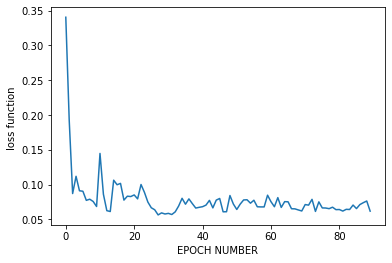

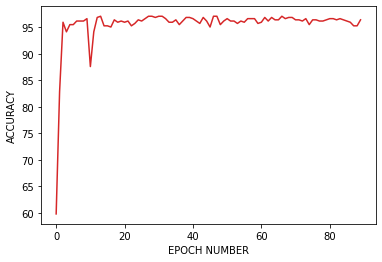

In [6]:
loss,accuracy=cnn.Train(x_train, y_train, 0.2, 90)
Show_Loss_Acc(loss, accuracy)

In [7]:
print_predict(cnn, x_test, y_test)

Input:[0.4 0.1 0.2 0.1 0.2 0.1 0.2 0.1 0.1]-- Real:[1 0] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.6 1.  0.2 0.8 1.  0.2 0.7 0.8 1. ]-- Real:[0 1] predict: [[0. 1.]] predict_float:[[0.08 0.92]]
Input:[0.8 1.  1.  1.  0.8 1.  1.  0.7 0.3]-- Real:[0 1] predict: [[0. 1.]] predict_float:[[0.08 0.92]]
Input:[0.5 1.  1.  0.3 0.8 0.1 0.5 1.  0.3]-- Real:[0 1] predict: [[0. 1.]] predict_float:[[0.08 0.92]]
Input:[0.3 0.1 0.1 0.1 0.3 0.1 0.2 0.1 0.1]-- Real:[1 0] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.4 0.1 0.1 0.3 0.2 0.1 0.3 0.1 0.1]-- Real:[1 0] predict: [[1. 0.]] predict_float:[[1. 0.]]
Input:[0.5 0.3 0.3 0.3 0.6 1.  0.3 0.1 0.1]-- Real:[0 1] predict: [[0. 1.]] predict_float:[[0.08 0.92]]
Input:[1.  1.  1.  0.8 0.6 0.1 0.8 0.9 0.1]-- Real:[0 1] predict: [[0. 1.]] predict_float:[[0.08 0.92]]
Input:[0.9 0.9 1.  0.3 0.6 1.  0.7 1.  0.6]-- Real:[0 1] predict: [[0. 1.]] predict_float:[[0.08 0.92]]
Input:[0.1 0.2 0.2 0.1 0.2 0.1 0.2 0.1 0.1]-- Real:[1 0] predict: [[1. 0.]] 